### Load & Plot Functions

In [1]:
# Load modules
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load data
# Download latest version
path = kagglehub.dataset_download("pecanstreetinc/ps-data-10-homes-1min-frequency-aug-2018")

#print("Path to dataset files:", path)

# Create dataframe
psdf = pd.read_csv(f"{path}/PecanStreet_10_Homes_1Min_Data.csv")

In [2]:
# plot function
def plot_lineplot(dataframe, xcol, ycol, hue_var, title):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.grid(linestyle='--', color='gray', alpha=0.6)
    if hue_var == 'none':
        sns.scatterplot(data=dataframe, x=xcol, y=ycol, ax=ax, s=2, palette='deep', legend=False)
    else:
        sns.scatterplot(data=dataframe, x=xcol, y=ycol, hue=hue_var, ax=ax, s=2, palette='deep', legend=False)
    ax.set_title(title)

### EDA

In [3]:
# Explore dataframe values
print(psdf['Circuit'].unique())        # print unique column values
print(psdf['Measure'].unique())        # print unique column values

# Explore data types
print(psdf.dtypes)

type(psdf['Datetime (UTC)'][0])        # datetime type

['HVAC Condenser' 'HVAC Fan' 'Solar' 'Main Panel']
['Real Power' 'Total Harmonic Distortion' 'Apparent Power' 'Phase Angle'
 'Current']
Home ID             int64
Datetime (UTC)     object
Circuit            object
Measure            object
Value             float64
dtype: object


str

In [4]:
# Configure dataframe to add datetime column with local time
psdf['Datetime'] = pd.to_datetime(psdf['Datetime (UTC)'])-pd.Timedelta(hours=5)
psdf

,Home ID,Datetime (UTC),Circuit,Measure,Value,Datetime
0,1,2018-08-23 00:00:00+00:00,HVAC Condenser,Real Power,3.802,2018-08-22 19:00:00+00:00
1,1,2018-08-23 00:01:00+00:00,HVAC Condenser,Real Power,3.804,2018-08-22 19:01:00+00:00
2,1,2018-08-23 00:02:00+00:00,HVAC Condenser,Real Power,3.789,2018-08-22 19:02:00+00:00
3,1,2018-08-23 00:03:00+00:00,HVAC Condenser,Real Power,3.788,2018-08-22 19:03:00+00:00
4,1,2018-08-23 00:04:00+00:00,HVAC Condenser,Real Power,3.784,2018-08-22 19:04:00+00:00
...,...,...,...,...,...,...
993825,10,2018-08-25 23:56:00+00:00,Main Panel,Current,2.687,2018-08-25 18:56:00+00:00
993826,10,2018-08-25 23:57:00+00:00,Main Panel,Current,2.686,2018-08-25 18:57:00+00:00
993827,10,2018-08-25 23:58:00+00:00,Main Panel,Current,2.688,2018-08-25 18:58:00+00:00
993828,10,2018-08-25 23:59:00+00:00,Main Panel,Current,2.685,2018-08-25 18:59:00+00:00


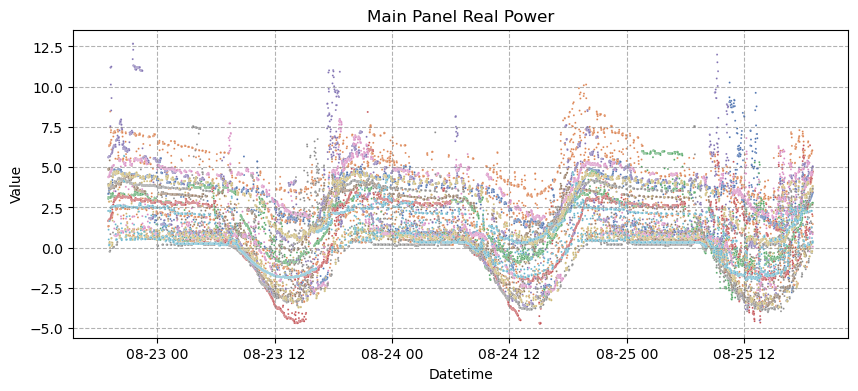

In [29]:
# Time series plots
circuitname = 'Main Panel'
measure = 'Real Power'

main_realpwr = psdf[(psdf['Circuit'] == circuitname) & (psdf['Measure'] == measure)]

# plot
plot_lineplot(main_realpwr, 'Datetime', 'Value', 'Home ID', f"{circuitname} Real Power")

### Manual Time-Series Forecasting: Peak Demand Analysis

#### Peak Demand as %ile of all data

peak load threshold value: 4.496


,Home ID,Datetime (UTC),Circuit,Measure,Value,Datetime
648177,1,2018-08-23 00:27:00+00:00,Main Panel,Real Power,4.591,2018-08-22 19:27:00+00:00
648178,1,2018-08-23 00:28:00+00:00,Main Panel,Real Power,4.633,2018-08-22 19:28:00+00:00
648179,1,2018-08-23 00:29:00+00:00,Main Panel,Real Power,4.597,2018-08-22 19:29:00+00:00
648180,1,2018-08-23 00:30:00+00:00,Main Panel,Real Power,4.611,2018-08-22 19:30:00+00:00
648181,1,2018-08-23 00:31:00+00:00,Main Panel,Real Power,4.646,2018-08-22 19:31:00+00:00
...,...,...,...,...,...,...
689889,10,2018-08-24 23:30:00+00:00,Main Panel,Real Power,4.542,2018-08-24 18:30:00+00:00
689890,10,2018-08-24 23:31:00+00:00,Main Panel,Real Power,4.575,2018-08-24 18:31:00+00:00
689891,10,2018-08-24 23:32:00+00:00,Main Panel,Real Power,4.543,2018-08-24 18:32:00+00:00
689892,10,2018-08-24 23:33:00+00:00,Main Panel,Real Power,4.532,2018-08-24 18:33:00+00:00


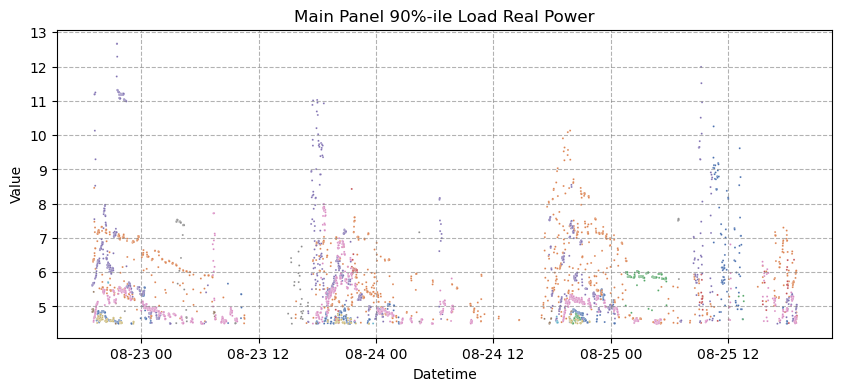

In [30]:
# Find peak demand times

# choose circuit (change as desired)
circuitname = 'Main Panel'

circuit_df = psdf[(psdf['Circuit'] == circuitname) & (psdf['Measure'] == 'Real Power')]

# define peak load threshold as Xth percentile of measure
peak_thresh_pct = 90
peak_thresh = np.percentile(circuit_df['Value'], peak_thresh_pct)
print(f"peak load threshold value: {peak_thresh}")

# find datetimes of peak load & plot
peak_df = circuit_df[circuit_df['Value'] >= peak_thresh]
plot_lineplot(peak_df, 'Datetime', 'Value', 'Home ID', f"{circuitname} {peak_thresh_pct}%-ile Load Real Power")

peak_df

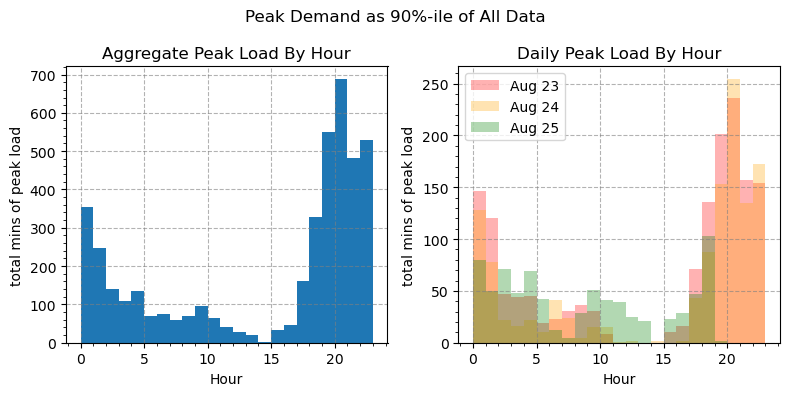

In [31]:
# Histograms of peak load
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

# aggregate histogram
peak_hrs = peak_df['Datetime'].dt.hour

axs[0].hist(peak_hrs, bins=np.arange(24))
axs[0].set_ylabel(f"total mins of peak load")
axs[0].set_xlabel(f"Hour")
axs[0].grid(linestyle='--', color='gray', alpha=0.6)
axs[0].minorticks_on()
axs[0].set_title(f"Aggregate Peak Load By Hour")


# daily histograms of peak load
days = np.arange(23,26)
colors = ['red','orange','green']

for i in range(len(days)):
    filtered = peak_df[peak_df['Datetime'].dt.day == days[i]]
    axs[1].hist(filtered['Datetime'].dt.hour, bins=np.arange(24), color=colors[i], alpha=0.3, label=f"Aug {days[i]}")
    axs[1].grid(linestyle='--', color='gray', alpha=0.6)
    axs[1].minorticks_on()
axs[1].set_title(f"Daily Peak Load By Hour")
axs[1].set_ylabel(f"total mins of peak load")
axs[1].set_xlabel(f"Hour")
axs[1].legend()

fig.suptitle(f"Peak Demand as {peak_thresh_pct}%-ile of All Data")
plt.tight_layout()

#### Peak Demand as Daily %-ile

peak load threshold value: 5.325099999999999
peak load threshold value: 4.922
peak load threshold value: 4.907649999999998


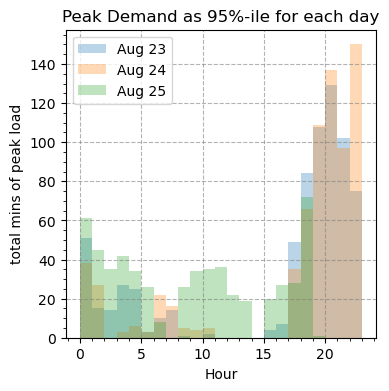

In [32]:
# Find peak demand times
daily_peak_thresh_pct = 95

days = np.arange(23,26)
fig, ax = plt.subplots(figsize=(4,4)) # aggregate plot

for d in days:
    day_filtered = circuit_df[circuit_df['Datetime'].dt.day == d]
    peak_thresh = np.percentile(day_filtered['Value'], daily_peak_thresh_pct)
    print(f"peak load threshold value: {peak_thresh}")

    # find datetimes of peak load & plot
    peak_df = day_filtered[day_filtered['Value'] >= peak_thresh]
    #plot_lineplot(peak_df, 'Datetime', 'Value', 'Home ID', f"{circuitname} {peak_thresh_pct}%-ile Load Real Power")

    peak_hrs = peak_df['Datetime'].dt.hour

    #fig, ax = plt.subplots(figsize=(4,4)) # plot separately
    ax.hist(peak_hrs, bins=np.arange(24), alpha=0.3, label=f"Aug {d}")
    ax.set_ylabel(f"total mins of peak load")
    ax.set_xlabel(f"Hour")
    ax.grid(linestyle='--', color='gray', alpha=0.6)
    ax.minorticks_on()
    ax.set_title(f"Peak Demand as {daily_peak_thresh_pct}%-ile for each day")
ax.legend()

#### Peak Demand as Household %-ile

peak load threshold value: 4.838
peak load threshold value: 6.944
peak load threshold value: 4.431
peak load threshold value: 3.343
peak load threshold value: 7.079
peak load threshold value: 3.968
peak load threshold value: 5.45
peak load threshold value: 4.148
peak load threshold value: 4.438
peak load threshold value: 2.612


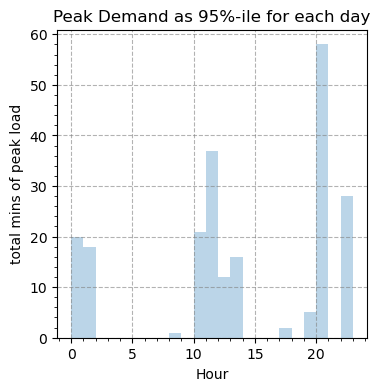

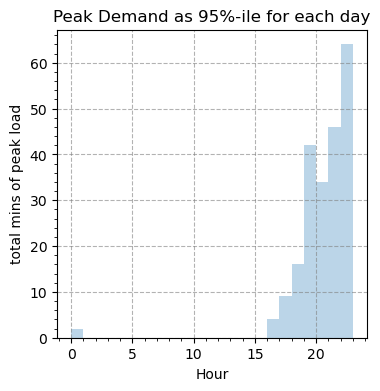

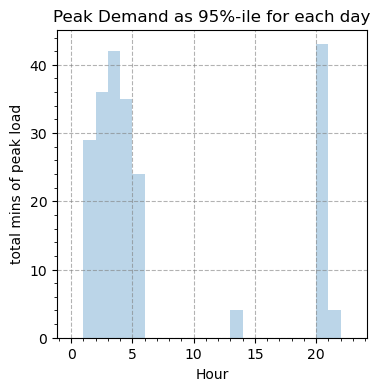

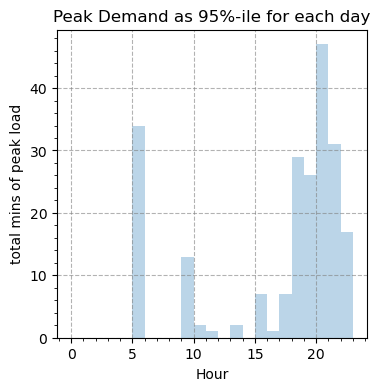

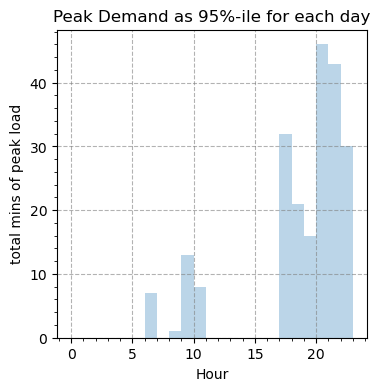

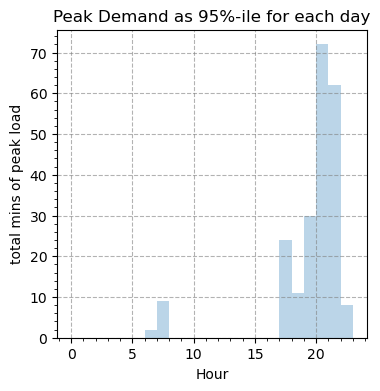

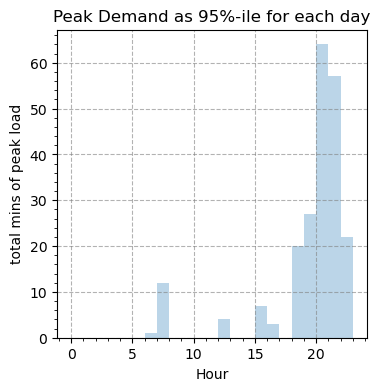

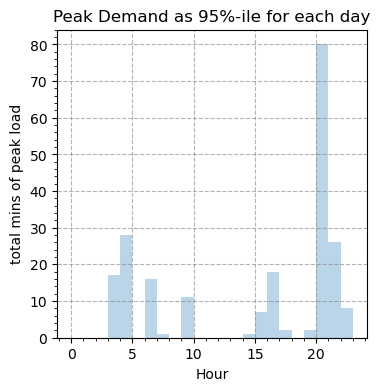

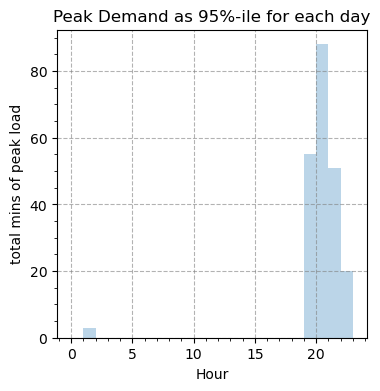

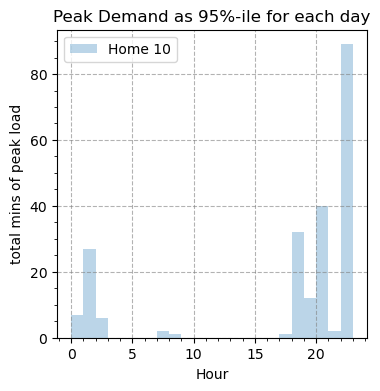

In [33]:
# Find peak demand times
house_peak_thresh_pct = 95

households = np.arange(1,11)
#fig, ax = plt.subplots(figsize=(4,4)) # aggregate plot

for h in households:
    house_filtered = circuit_df[circuit_df['Home ID'] == h]
    peak_thresh = np.percentile(house_filtered['Value'], house_peak_thresh_pct)
    print(f"peak load threshold value: {peak_thresh}")

    # find datetimes of peak load & plot
    peak_df = house_filtered[house_filtered['Value'] >= peak_thresh]
    #plot_lineplot(peak_df, 'Datetime', 'Value', 'Home ID', f"{circuitname} {peak_thresh_pct}%-ile Load Real Power")

    peak_hrs = peak_df['Datetime'].dt.hour

    fig, ax = plt.subplots(figsize=(4,4)) # plot separately
    ax.hist(peak_hrs, bins=np.arange(24), alpha=0.3, label=f"Home {h}")
    ax.set_ylabel(f"total mins of peak load")
    ax.set_xlabel(f"Hour")
    ax.grid(linestyle='--', color='gray', alpha=0.6)
    ax.minorticks_on()
    ax.set_title(f"Peak Demand as {house_peak_thresh_pct}%-ile for each day")
ax.legend()

#### Results
**Main panel**

Evidently bimodal 90-95%-ile peak load typically occurs in (across all 10 homes):
* afternoon/evening (4pm-12am) **largest demand**
* morning (~9am) appears

August 25th had the highest demand of all 3 days.

Each home seems to exhibit this trend as well.
**However, individual home peak loads are more variable.**


**HVAC Condenser**

Bimodal 90-95%-ile peak load across all 10 homes & generally within each home:
* Before vs. after 3pm

**HVAC Fan**

Multi-modal distribution that varies by house but typically peaks in evening hours.

### ARIMA Time-Series Forecasting

Resources for creating ARIMA Model:
* https://www.datacamp.com/tutorial/arima
* https://www.ibm.com/think/topics/arima-model
* https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels.tsa.arima.model.ARIMA.__init__.trend
* https://otexts.com/fpp3/
* Egor Howell Youtube channel: https://www.youtube.com/watch?v=GcJ__g_cimA

#### Parameter Tuning

/var/folders/xb/h7r1m3_s45x6dg5cbwyvvgd40000gn/T/ipykernel_37965/3249015638.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=avg_main_realpwr, x='Datetime', y='Value', ax=ax, s=2, palette='deep', legend=False, label='Value')


Text(0.5, 1.0, 'Average Main Panel Power')

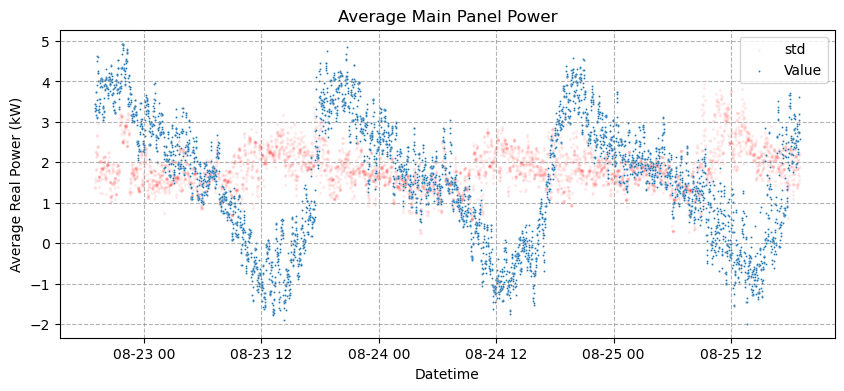

In [34]:
# find average mean power time series across all homes to model time series for forecasting
avg_main_realpwr = main_realpwr.groupby('Datetime').mean('Value').drop(columns='Home ID')
std_main_realpwr = main_realpwr.groupby('Datetime')['Value'].std().drop(columns='Home ID') # get std


fig, ax = plt.subplots(figsize=(10,4))
ax.grid(linestyle='--', color='gray', alpha=0.6)
ax.scatter(avg_main_realpwr.index, std_main_realpwr, s=2, color='red', label='std', alpha=0.05) # plot std values
sns.scatterplot(data=avg_main_realpwr, x='Datetime', y='Value', ax=ax, s=2, palette='deep', legend=False, label='Value')
ax.set_ylabel(f"Average Real Power (kW)")
ax.legend()
ax.set_title(f"Average Main Panel Power")

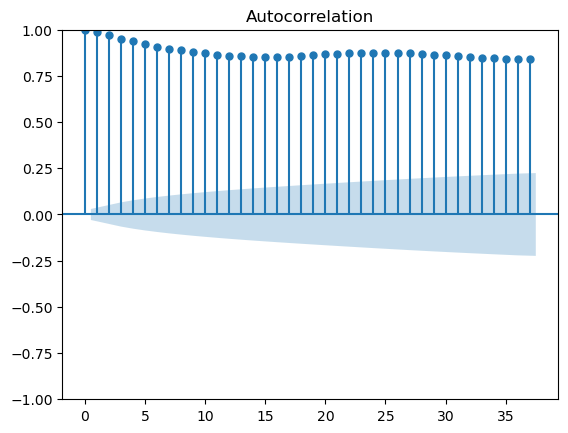

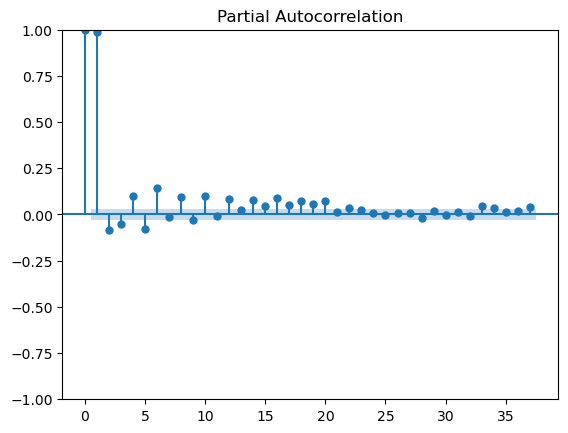

In [35]:
# determine ARIMA p, d, q parameters using ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF & PACF on non-differenced data
plot_acf(avg_main_realpwr)
plot_pacf(avg_main_realpwr)
plt.show()

ACF test on non-differenced data shows slowly decreasing, significant ACFs for many lags.

This indicates that the data is non-stationary and requires differencing.

test difference order d = 1


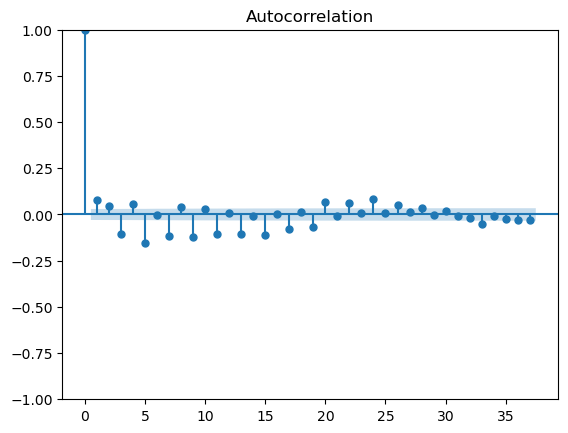

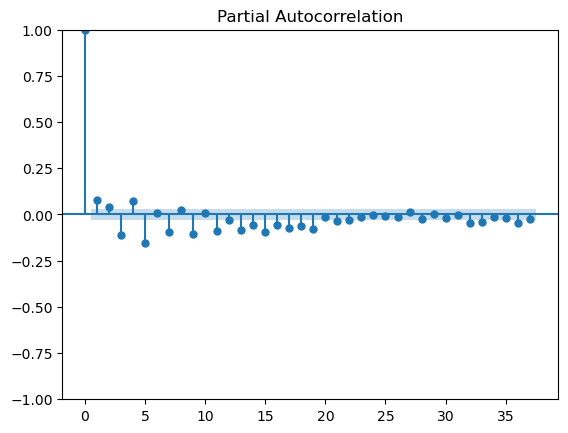

test difference order d = 2


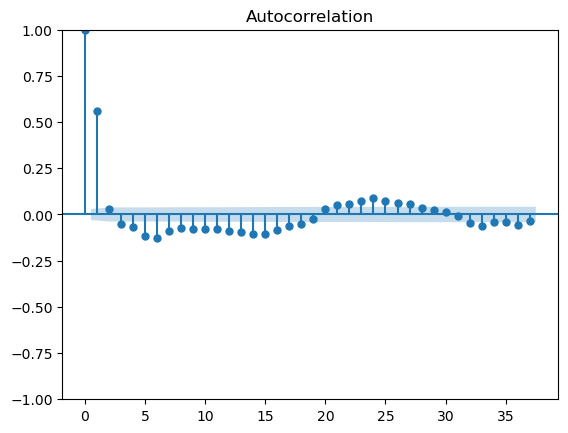

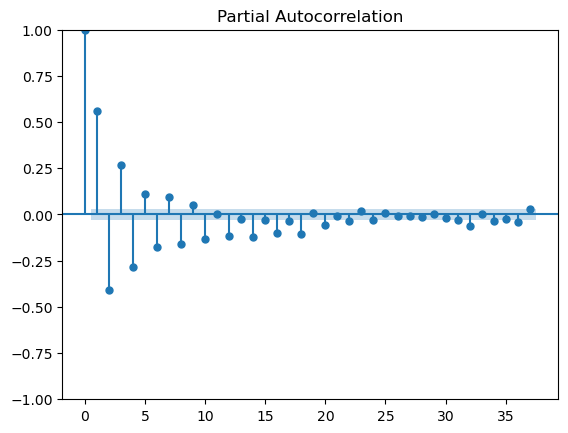

test difference order d = 3


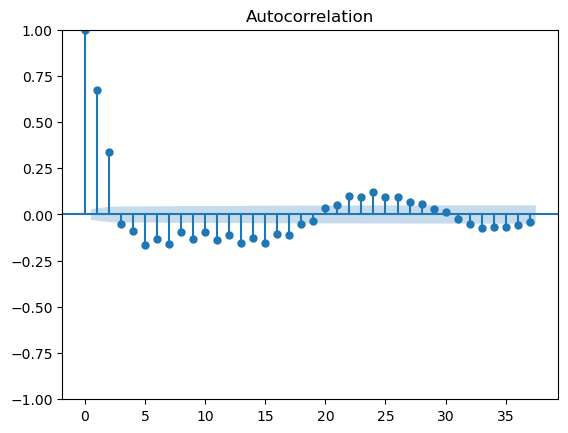

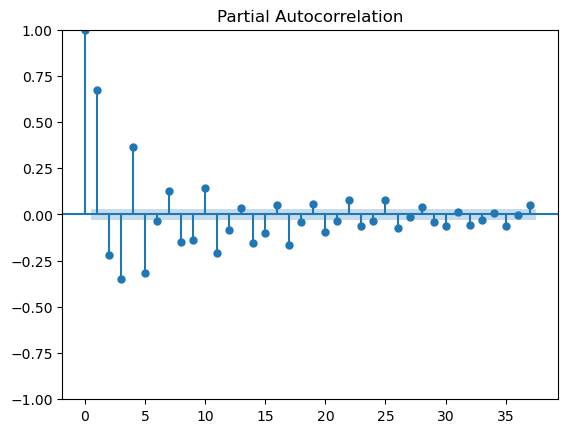

test difference order d = 4


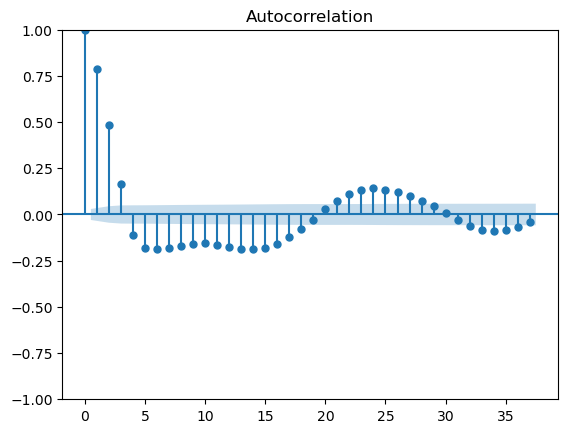

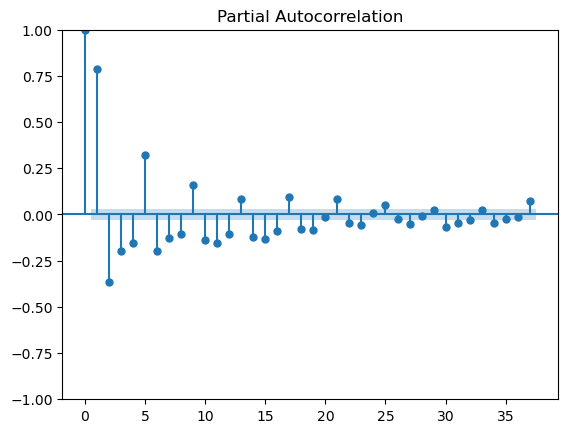

test difference order d = 5


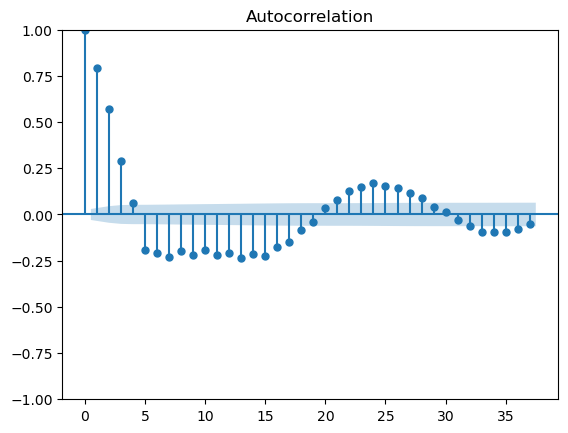

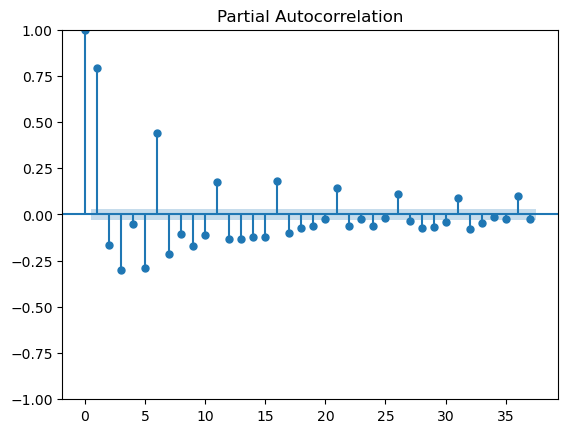

test difference order d = 6


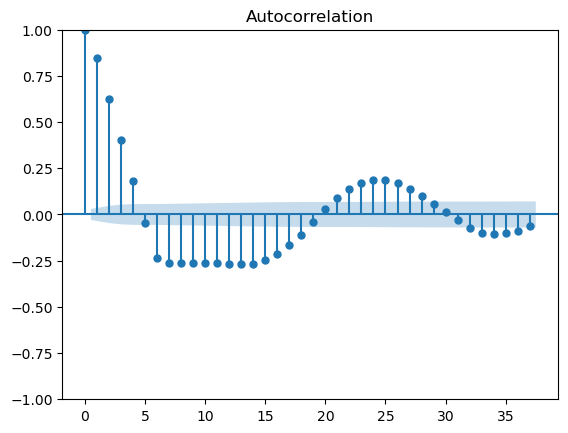

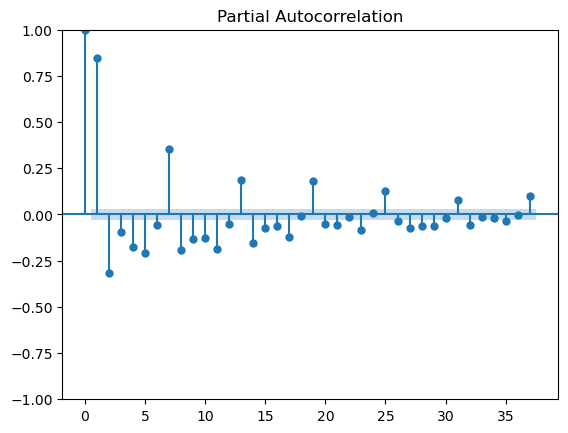

test difference order d = 7


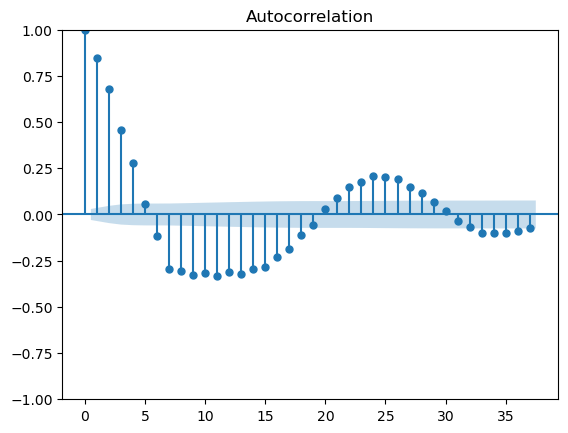

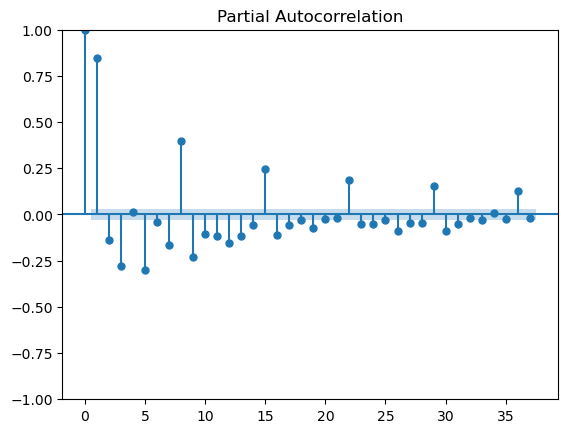

test difference order d = 8


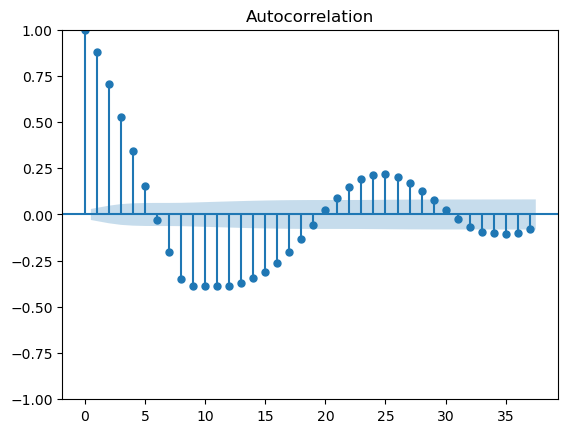

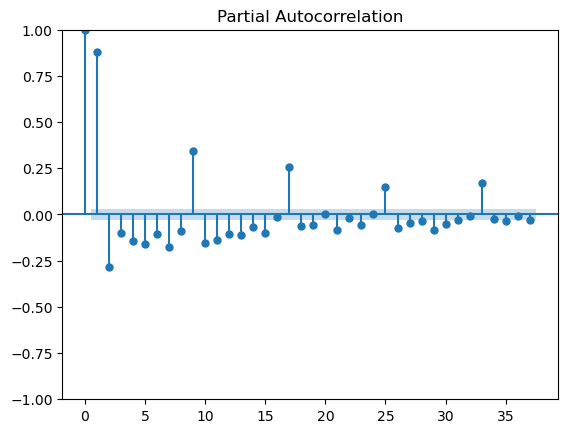

test difference order d = 9


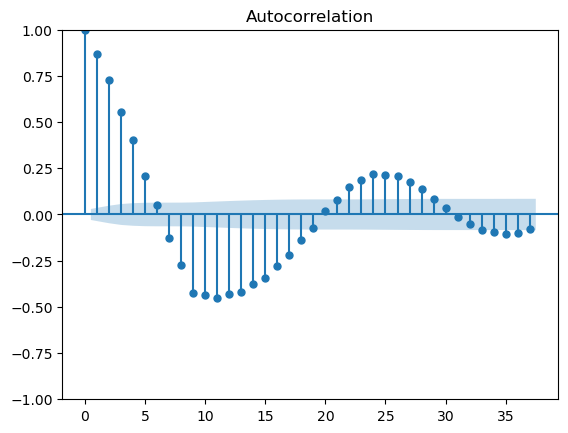

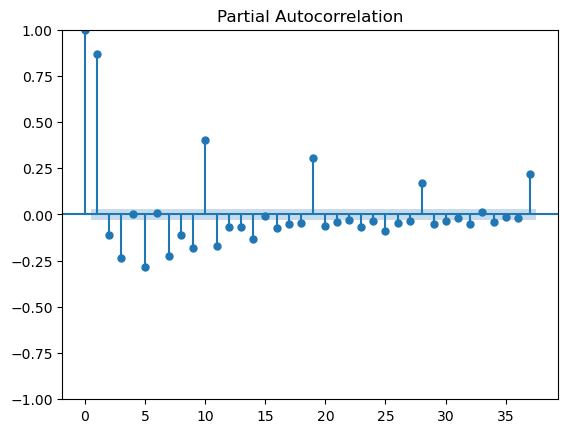

test difference order d = 10


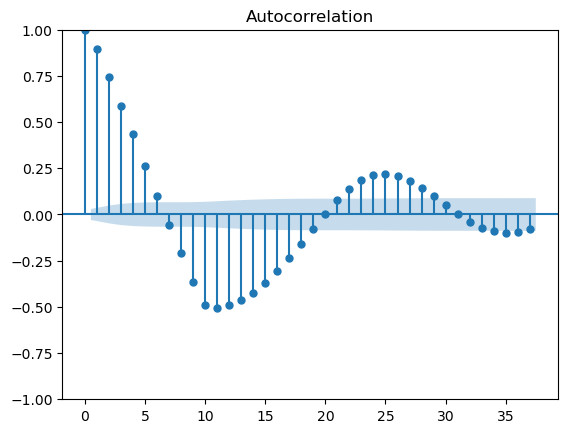

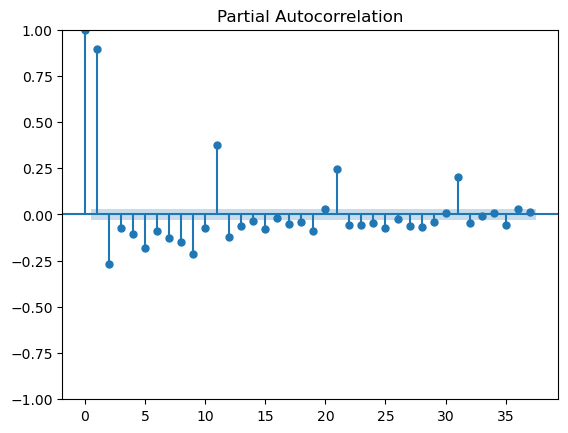

In [36]:
# differencing trials
# implement ACF & PACF on data differenced with varying periods

maxdiff = 10 # test up to difference order of 10 (i.e. d=10 in ARIMA model)

# visually determine 
for i in range(1, maxdiff+1):
    newdata = avg_main_realpwr.diff(periods=i).dropna()
    print(f"test difference order d = {i}")
    plot_acf(newdata)
    plot_pacf(newdata)
    plt.show()

Interpreting the differencing trial results:
* oscillating correlations of 40-50 minute periods indicate that time series is affected by cyclic process (i.e. HVAC cycles, thermostat loops which typically run 10-20 minutes at a time to reach desired temperatures)
* oscillations with overly high amplitudes may indicate over-differencing

Based on the differencing trials, one of the following seem to be the best parameters for an ARIMA model:
* (d=0, p=1, q=1)
* (d=1, p=0, q=0)
* (d=2, p=0 or 1, q=0 or 1)

Text(0, 0.5, 'Average Real Power (kW)')

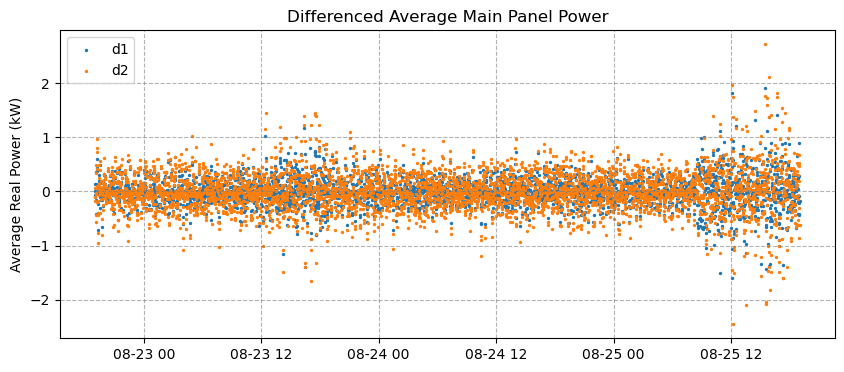

In [37]:
# plot d=1 and d=2 differenced data
d1data = avg_main_realpwr.diff(periods=1).dropna()
d2data = avg_main_realpwr.diff(periods=2).dropna()

fig, ax = plt.subplots(figsize=(10,4))
ax.grid(linestyle='--', color='gray', alpha=0.6)
#ax.plot(d1data.index, d1data, label='d1', lw=0.5, alpha=0.5) #lineplot
#ax.plot(d2data.index, d2data, label='d2', lw=0.5, alpha=0.5) #lineplot
ax.scatter(d1data.index, d1data, s=2, label='d1') #scatterplot
ax.scatter(d2data.index, d2data, s=2, label='d2') #scatterplot
ax.legend()
ax.set_title(f"Differenced Average Main Panel Power")
ax.set_ylabel(f"Average Real Power (kW)")

#### Train vs. Test Split for ARIMA

Text(0.5, 1.0, 'Train vs. Test Split Main Panel Power')

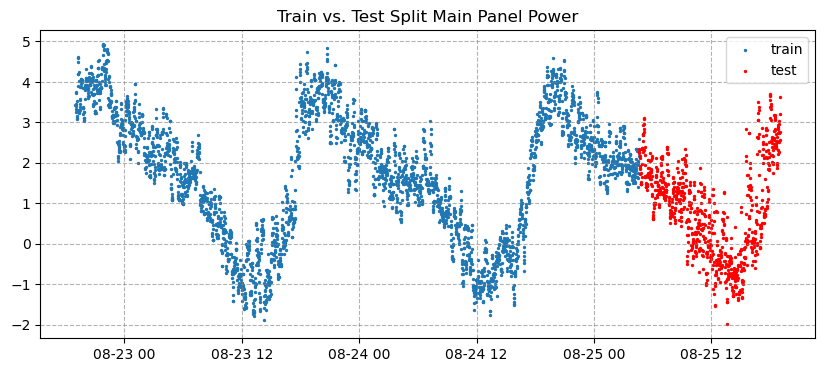

In [38]:
# training vs. testing data split
train_pct = 0.8  # set % of data to use for training
last_train_index = int(train_pct*len(avg_main_realpwr))

trainingdata = avg_main_realpwr.iloc[:last_train_index]
testdata = avg_main_realpwr.iloc[last_train_index:]


# visualize data split
fig, ax = plt.subplots(figsize=(10,4))
ax.grid(linestyle='--', color='gray', alpha=0.6)
ax.scatter(trainingdata.index, trainingdata, s=2, label='train')
ax.scatter(testdata.index, testdata, s=2, label='test', color='red')
ax.legend()
ax.set_title(f"Train vs. Test Split Main Panel Power")

#### ARIMA Models
Using train vs. test split

Change the model parameters to test different models.

In [39]:
# Build ARIMA model
from statsmodels.tsa.arima.model import ARIMA

def ARIMA_model(p, d, q, printButton):
    mod = ARIMA(endog=trainingdata, order=(p, d, q))
    res = mod.fit() # model results

    # print summary & results
    if printButton == 1:
        print(res.summary())
        residuals = pd.DataFrame(res.resid)
        residuals.plot()
        print(residuals.describe())

    return res

In [40]:
# Time-series forecast
# forecast_ARIMA() contains ARIMA_model

from statsmodels.tools.eval_measures import rmse

def forecast_ARIMA(p, d, q, printButton):
    fitted_model = ARIMA_model(p, d, q, printButton)
    forecast = fitted_model.forecast(steps=len(testdata))
    rmse_val = rmse(forecast, testdata['Value'])

    if printButton == 1:
        # plot forecast
        fig, ax = plt.subplots(figsize=(10,4))
        ax.grid(linestyle='--', color='gray', alpha=0.6)
        ax.scatter(forecast.index, forecast, s=2, label='forecast', color='red')
        ax.set_title(f"ARIMA({p},{d},{q}) Model Forecast")


        # plot test data against ARIMA forecast
        # compare values during ERCOT event period
        fig, ax = plt.subplots(figsize=(10,4))
        ax.grid(linestyle='--', color='gray', alpha=0.6)
        ax.scatter(trainingdata.index, trainingdata, s=2, label='train')
        ax.scatter(testdata.index, testdata, s=2, label='test')
        ax.scatter(forecast.index, forecast, s=2, label='forecast', color='red')
        ax.legend()
        ax.set_title(f"ARIMA({p},{d},{q}) Model")

        # print RMSE
        print("")
        print(f"ARIMA({p},{d},{q}) RMSE: {round(rmse_val,4)}")
    
    return rmse_val, fitted_model.aic, fitted_model.bic

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 3456
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 556.060
Date:                Sat, 10 Jan 2026   AIC                          -1106.120
Time:                        21:28:52   BIC                          -1087.677
Sample:                    08-22-2018   HQIC                         -1099.533
                         - 08-25-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2409      0.075      3.204      0.001       0.094       0.388
ma.L1         -0.0757      0.076     -1.000      0.317      -0.224       0.073
sigma2         0.0424      0.001     63.185      0.0

(2.1497131346299856, -1106.1197562184432, -1087.677023009838)

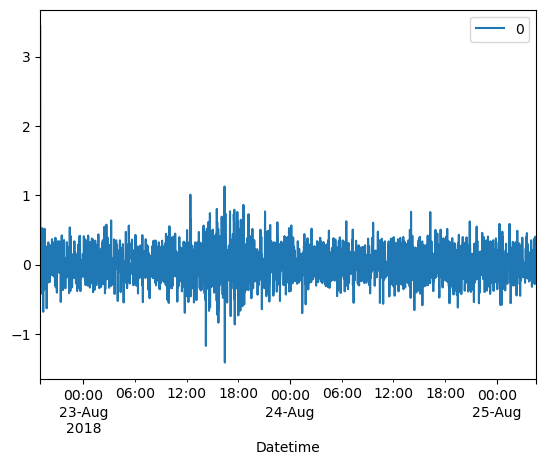

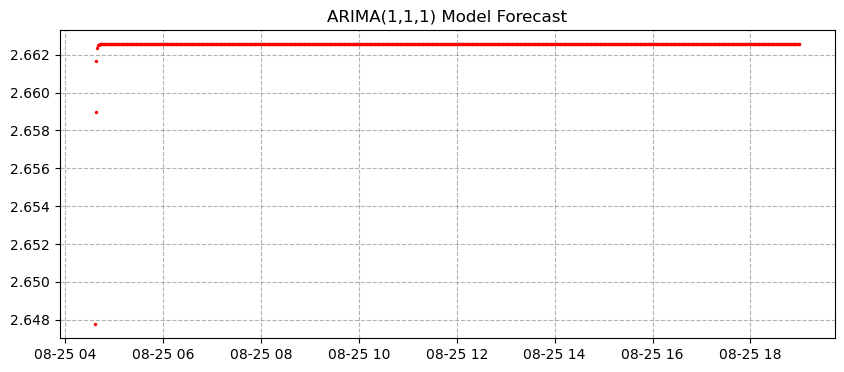

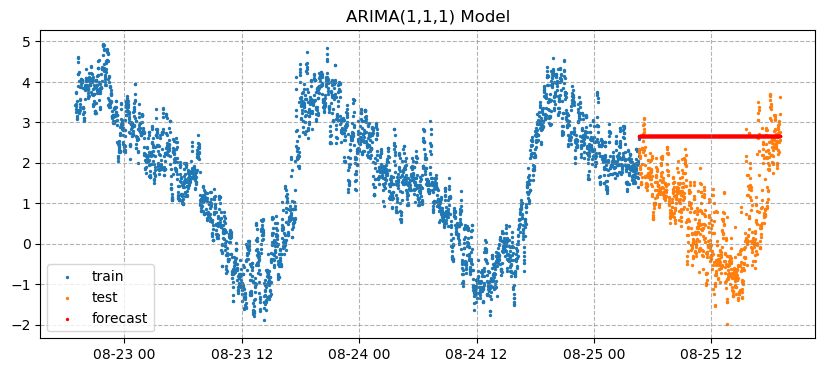

In [41]:
# Example
forecast_ARIMA(1, 1, 1, 1)

#### Model Tuning

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will b

Text(0.5, 1.0, 'AIC/BIC values')

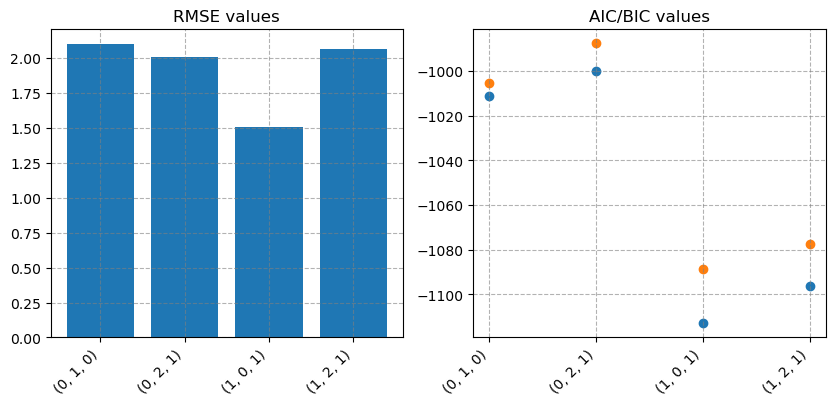

In [42]:
# test diff ARIMA (p, d, q) parameters

params_totest = [(0, 1, 0), (0, 2, 1), (1, 0, 1), (1, 2, 1)] # adjust with new parameter combinations as desired

rmses = np.zeros(len(params_totest))
aics = np.zeros(len(params_totest))
bics = np.zeros(len(params_totest))
i = 0

for tuple in params_totest:
    rmse_val, aic, bic = forecast_ARIMA(tuple[0], tuple[1], tuple[2], 0)
    rmses[i] = rmse_val
    aics[i] = aic
    bics[i] = bic
    i += 1

# plot model score values
xaxes = [str(tuple) for tuple in params_totest]

# rmse, aic/bic plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].bar(np.arange(len(rmses)), rmses)
axs[0].grid(linestyle='--', color='gray', alpha=0.6)
axs[0].set_xticks(np.arange(len(rmses)))
axs[0].set_xticklabels(xaxes, rotation=45, ha='right')
axs[0].set_title(f"RMSE values")

axs[1].scatter(np.arange(len(aics)), aics)
axs[1].scatter(np.arange(len(bics)), bics)
axs[1].grid(linestyle='--', color='gray', alpha=0.6)
axs[1].set_xticks(np.arange(len(rmses)))
axs[1].set_xticklabels(xaxes, rotation=45, ha='right')
axs[1].set_title(f"AIC/BIC values")

#### ARIMA Results
ARIMA(1,0,1) had the smallest RMSE score, making it the most accurate forecasting models for the 3-day Pecan Street data, as seen by the previous visualization.

However, as seen by the forecasting visualization in the next cell, even this did not accurately capture the detailed minute-by-minute trends of the power data.

Similarly, the AIC & BIC values were closest to 0 for ARIMA(0,2,1) with ARIMA(1,0,1) having the largest absolute values of AIC & BIC values.

Other Notes:
* Less training data (lower values for train_pct) typically led to lower RMSE values in both ARIMA models because the forecasted points were closer to the average power value.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 3456
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 560.539
Date:                Sat, 10 Jan 2026   AIC                          -1113.078
Time:                        21:29:01   BIC                          -1088.487
Sample:                    08-22-2018   HQIC                         -1104.296
                         - 08-25-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7940      0.320      5.605      0.000       1.167       2.421
ar.L1          0.9876      0.003    393.264      0.000       0.983       0.993
ma.L1          0.1581      0.014     11.525      0.0

(1.5050831388969155, -1113.0783191950848, -1088.486850675389)

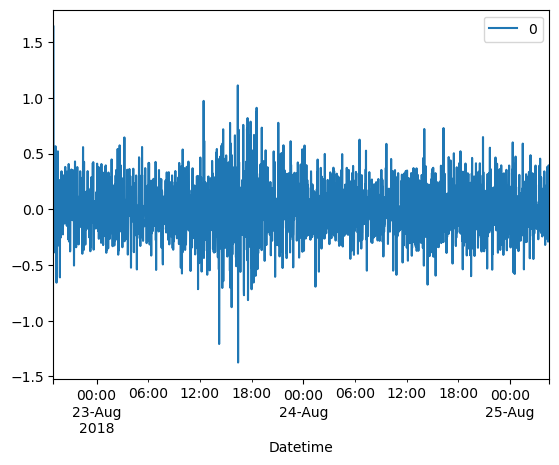

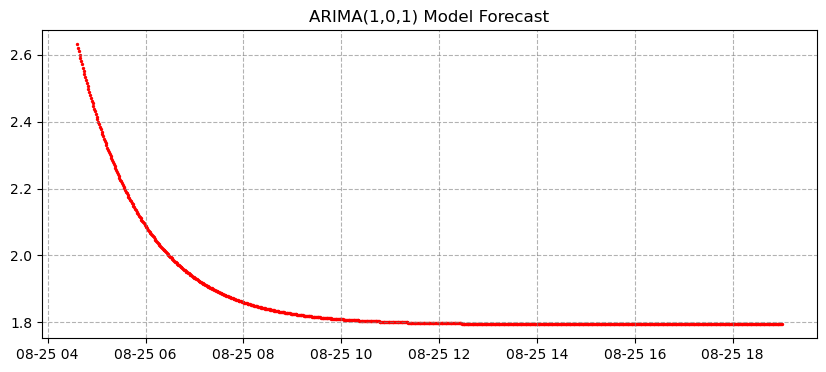

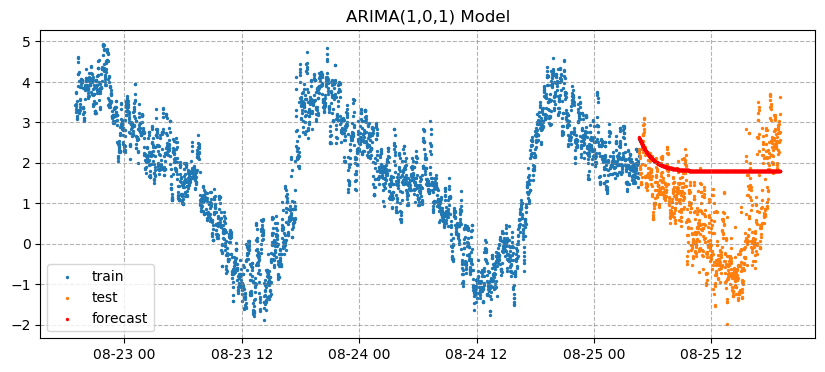

In [43]:
# Plot "best" model
forecast_ARIMA(1, 0, 1, 1)

### Weather Analysis as Driver of Peak Load
Austin minute frequency weather data: https://www.ncei.noaa.gov/cdo-web/datatools/lcd

* Location: AUSTIN CAMP MABRY, TX US

Camelot PDF-table parsing resource: https://camelot-py.readthedocs.io/en/master/

In [ ]:
# read table from weather PDFs
import camelot

folder_path = 'insert_filepath_here' # insert filepath here

filenames = ['aug23', 'aug24', 'aug25-1', 'aug25-2']

for file in filenames:
    tables = camelot.read_pdf(f"{folder_path}/{file}.pdf", pages='all', flavor='stream')
    temp_df = tables[0].df
    if file == 'aug25-2':
        # configure for correct formatting since 2nd page is parsed differently
        temp_df = temp_df.drop(index=[i for i in (1, 3)])
        temp_df = pd.concat([temp_df.iloc[:,:5], temp_df.iloc[:,5:].shift(periods=1, axis='columns')], axis='columns')
    else:
        temp_df = temp_df.drop(index=[i for i in range(12)]) # remove string headings
    
    if file == 'aug23': # create weather_df from first file
        weather_df = temp_df
    else:
        weather_df = pd.concat([weather_df, temp_df])

# configure dataframe column labels
col_labels = ['Date', 'Time LST', 'Station Type', 'Sky Conditions', 'Visibility', 'Weather Type', 'Dry Bulb Temp F', 'Dry Bulb Temp C', 'Wet Bulb Temp F', 'Wet Bulb Temp C', 'Dew Point Temp F', 'Dew Point C', 'Rel Hum Pct', 'Windspeed MPH', 'Wind Dir Deg', 'Wind Gusts MPH', 'Station Press inHg', 'Press Tend', 'Net 3-Hr Change inHg', 'Sea Level Press inHg', 'Report Type', 'Precip Total in', 'Alti-meter Setting inHg']
weather_df = weather_df.set_axis(col_labels, axis='columns')

# drop empty string rows
weather_df = weather_df[weather_df['Date'] != '']

# create weather Datetime column
date_strings = [f"2018-08-{weather_df['Date'].iloc[i]} {weather_df['Time LST'].iloc[i][:2]}:{weather_df['Time LST'].iloc[i][2:]}:00" for i in range(len(weather_df))]

datetime_col = [pd.to_datetime(datestring) for datestring in date_strings]

weather_df.insert(0, 'Datetime', datetime_col)
weather_df['Datetime'] = weather_df['Datetime'].dt.tz_localize('UTC')
weather_df

,Datetime,Date,Time LST,Station Type,Sky Conditions,Visibility,Weather Type,Dry Bulb Temp F,Dry Bulb Temp C,Wet Bulb Temp F,...,Windspeed MPH,Wind Dir Deg,Wind Gusts MPH,Station Press inHg,Press Tend,Net 3-Hr Change inHg,Sea Level Press inHg,Report Type,Precip Total in,Alti-meter Setting inHg
12,2018-08-23 00:51:00+00:00,23,0051,7,CLR:00,10.00,,85,29.4,73,...,0,000,,29.37,,,30.03,FM-15,0.00,30.08
13,2018-08-23 01:51:00+00:00,23,0151,7,CLR:00,10.00,,83,28.3,72,...,0,000,,29.37,,,30.03,FM-15,0.00,30.08
14,2018-08-23 02:51:00+00:00,23,0251,7,CLR:00,10.00,,82,27.8,72,...,0,000,,29.37,0,0.00,30.02,FM-15,0.00,30.08
15,2018-08-23 03:51:00+00:00,23,0351,7,CLR:00,10.00,,81,27.2,72,...,0,000,,29.37,,,30.03,FM-15,0.00,30.08
16,2018-08-23 04:51:00+00:00,23,0451,7,CLR:00,10.00,,79,26.1,71,...,0,000,,29.38,,,30.03,FM-15,0.00,30.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,2018-08-25 19:51:00+00:00,25,1951,7,CLR:00,10.00,,93,33.9,74,...,6,130,,29.26,,,29.92,FM-15,0.00,29.97
64,2018-08-25 20:51:00+00:00,25,2051,7,CLR:00,10.00,,89,31.7,75,...,14,130,23,29.29,3,-0.05,29.95,FM-15,0.00,30.00
0,2018-08-25 21:51:00+00:00,25,2151,7,BKN:07 70,10.00,None,88,31.1,74,...,10,140,,29.33,,,29.99,FM-15,0.00,NaN
2,2018-08-25 22:51:00+00:00,25,2251,7,,10.00,None,86,30.0,73,...,10,VRB,22,29.36,,,30.02,FM-15,0.00,NaN


In [45]:
# combine weather & power datafraes by
# mapping weather Datetime to power data Datetime
main_realpwr = main_realpwr.sort_values(by=['Datetime']) # sort main_realpwr Datetime keys
desired_weather_cols = ['Datetime','Dry Bulb Temp F', 'Dry Bulb Temp C', 'Wet Bulb Temp F', 'Wet Bulb Temp C']

big_df = pd.merge_asof(main_realpwr, weather_df[desired_weather_cols], on="Datetime", direction="backward")

# change temperature column dtypes for plotting
temp_cols = ['Dry Bulb Temp F', 'Dry Bulb Temp C', 'Wet Bulb Temp F', 'Wet Bulb Temp C']
big_df[temp_cols] = big_df[temp_cols].astype('float')
big_df

,Home ID,Datetime (UTC),Circuit,Measure,Value,Datetime,Dry Bulb Temp F,Dry Bulb Temp C,Wet Bulb Temp F,Wet Bulb Temp C
0,1,2018-08-23 00:00:00+00:00,Main Panel,Real Power,3.339,2018-08-22 19:00:00+00:00,NaN,NaN,NaN,NaN
1,5,2018-08-23 00:00:00+00:00,Main Panel,Real Power,5.606,2018-08-22 19:00:00+00:00,NaN,NaN,NaN,NaN
2,6,2018-08-23 00:00:00+00:00,Main Panel,Real Power,4.916,2018-08-22 19:00:00+00:00,NaN,NaN,NaN,NaN
3,4,2018-08-23 00:00:00+00:00,Main Panel,Real Power,1.653,2018-08-22 19:00:00+00:00,NaN,NaN,NaN,NaN
4,10,2018-08-23 00:00:00+00:00,Main Panel,Real Power,2.292,2018-08-22 19:00:00+00:00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
43205,3,2018-08-26 00:00:00+00:00,Main Panel,Real Power,2.791,2018-08-25 19:00:00+00:00,95.0,35.0,73.0,22.8
43206,2,2018-08-26 00:00:00+00:00,Main Panel,Real Power,1.470,2018-08-25 19:00:00+00:00,95.0,35.0,73.0,22.8
43207,1,2018-08-26 00:00:00+00:00,Main Panel,Real Power,3.437,2018-08-25 19:00:00+00:00,95.0,35.0,73.0,22.8
43208,9,2018-08-26 00:00:00+00:00,Main Panel,Real Power,3.832,2018-08-25 19:00:00+00:00,95.0,35.0,73.0,22.8


#### EDA

Text(0.5, 1.0, 'Anomaly AVERAGE Power vs. Temperature')

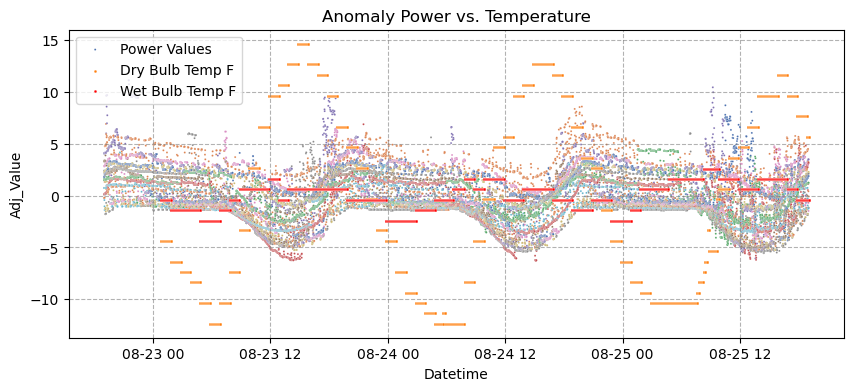

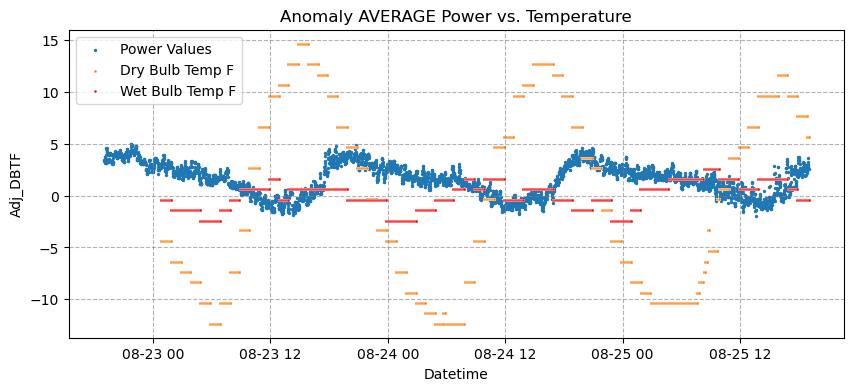

In [49]:
# prepare data for plotting
# adjust temp data to match power y-axis values
big_df['Adj_Value'] = big_df['Value'] - big_df['Value'].mean()
big_df['Adj_DBTF'] = big_df['Dry Bulb Temp F'] - big_df['Dry Bulb Temp F'].mean()
big_df['Adj_WBTF'] = big_df['Wet Bulb Temp F'] - big_df['Wet Bulb Temp F'].mean()


# plot power with weather data
fig, ax = plt.subplots(figsize=(10, 4))
sns.scatterplot(data=big_df, x='Datetime', y='Adj_Value', ax=ax, s=2, hue='Home ID', palette='deep', legend=False, label='Power Values')
sns.scatterplot(data=big_df, x='Datetime', y='Adj_DBTF', ax=ax, s=4, legend=False, label='Dry Bulb Temp F')
sns.scatterplot(data=big_df, x='Datetime', y='Adj_WBTF', ax=ax, s=4, legend=False, label='Wet Bulb Temp F', color='red')

ax.grid(linestyle='--', color='gray', alpha=0.6)
ax.legend()
ax.set_title(f"Anomaly Power vs. Temperature")


# plot avg power with weather data
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(avg_main_realpwr.index, avg_main_realpwr['Value'], s=2, label='Power Values')
sns.scatterplot(data=big_df, x='Datetime', y='Adj_DBTF', ax=ax, s=4, legend=False, label='Dry Bulb Temp F')
sns.scatterplot(data=big_df, x='Datetime', y='Adj_WBTF', ax=ax, s=4, legend=False, label='Wet Bulb Temp F', color='red')

ax.grid(linestyle='--', color='gray', alpha=0.6)
ax.legend()
ax.set_title(f"Anomaly AVERAGE Power vs. Temperature")

Text(0.5, 1.0, 'Anomaly Peak Power 90%-ile vs. Temperature')

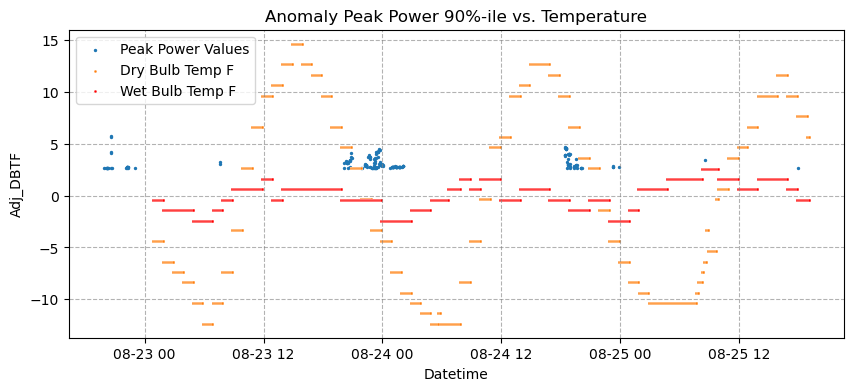

In [51]:
# Peak load vs. temperature
# Visually inspect times of peak load vs. temperature

fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(peak_df['Datetime'], peak_df['Value'], s=2, label='Peak Power Values')
sns.scatterplot(data=big_df, x='Datetime', y='Adj_DBTF', ax=ax, s=4, legend=False, label='Dry Bulb Temp F')
sns.scatterplot(data=big_df, x='Datetime', y='Adj_WBTF', ax=ax, s=4, legend=False, label='Wet Bulb Temp F', color='red')

ax.grid(linestyle='--', color='gray', alpha=0.6)
ax.legend()
ax.set_title(f"Anomaly Peak Power {peak_thresh_pct}%-ile vs. Temperature")

*Note: In this cell, "temperature" refers to Dry Bulb Temperature. Wet Bulb Temperature is specifically identified.*

#### Temperature vs. Power Load Cycles
By visual inspection, periodic peak temperature and power cycles are offset by ~3 hours, and minimum temperature and power cycles are offset by ~8 hours.
* i.e. Maximum power values occur ~3 hours after max temperatures are reached, and minimum power values occur ~8 hours after minimum temperatures are reached.

These phase differences indicate that power demand may lag behind temperature cycles by hours at a time. This could be due to several factors, such as the time it takes for HVAC systems and thermostats to compensate for temperature increases and decreases. It makes sense that there is a faster power adjustment to maximum temperature peaks, because it is more important to cool during relatively high temperatures thanr educe cooling at lower temperatures.

This aligns with typical AC cooling systems, which take around 3 hours to cool a four-bedroom house by 10 degrees F. Notice that the temperature cycle has an amplitude of 10-15 degrees, and peak power is consistently reached ~3 hours later.

#### Temperature vs. Peak Demand
Furthermore, peak loads in the 90s percentiles of energy consumption seem to occur with another noticeable offset/lag to the temperature cycle. The offset between peak temperature and peak load (in 90s percentiles) is more variable.
* On August 23, peak loads occur in evening.
* On August 24, peak loads occur beginning in mid-late afternoon.

Resources:
* https://www.dodrillheating.com/blog/2020/march/how-long-should-my-hvac-system-take-to-work-/#:~:text=How%20Long%20Should%20It%20Take,size%2C%20power%2C%20and%20age.
* https://uttkeheating.com/blog/how-long-does-it-take-to-cool-down-a-house/#:~:text=On%20average%2C%20a%20well%2Dfunctioning,looking%20at%20about%208%20hours

#### SARIMAX Model with Weather

Resources:
* https://www.geeksforgeeks.org/artificial-intelligence/what-is-an-arimax-model/

In [52]:
# combine average power df with temperature df
avg_main_realpwr = avg_main_realpwr.sort_values(by=['Datetime']) # sort main_realpwr Datetime keys
desired_weather_cols = ['Datetime','Dry Bulb Temp F', 'Dry Bulb Temp C', 'Wet Bulb Temp F', 'Wet Bulb Temp C']

avg_big_df = pd.merge_asof(avg_main_realpwr, weather_df[desired_weather_cols], on="Datetime", direction="backward")

# change temperature column dtypes for plotting
temp_cols = ['Dry Bulb Temp F', 'Dry Bulb Temp C', 'Wet Bulb Temp F', 'Wet Bulb Temp C']
avg_big_df[temp_cols] = avg_big_df[temp_cols].astype('float')
avg_big_df = avg_big_df[avg_big_df['Datetime'] >= pd.to_datetime('2018-08-23 00:51:00+0000')]
avg_big_df

,Datetime,Value,Dry Bulb Temp F,Dry Bulb Temp C,Wet Bulb Temp F,Wet Bulb Temp C
351,2018-08-23 00:51:00+00:00,2.7227,85.0,29.4,73.0,22.8
352,2018-08-23 00:52:00+00:00,2.6892,85.0,29.4,73.0,22.8
353,2018-08-23 00:53:00+00:00,2.7056,85.0,29.4,73.0,22.8
354,2018-08-23 00:54:00+00:00,2.9308,85.0,29.4,73.0,22.8
355,2018-08-23 00:55:00+00:00,3.2629,85.0,29.4,73.0,22.8
...,...,...,...,...,...,...
4316,2018-08-25 18:56:00+00:00,2.7291,95.0,35.0,73.0,22.8
4317,2018-08-25 18:57:00+00:00,3.6217,95.0,35.0,73.0,22.8
4318,2018-08-25 18:58:00+00:00,3.1995,95.0,35.0,73.0,22.8
4319,2018-08-25 18:59:00+00:00,2.7593,95.0,35.0,73.0,22.8


Text(0.5, 1.0, 'Train vs. Test Split Main Panel Power')

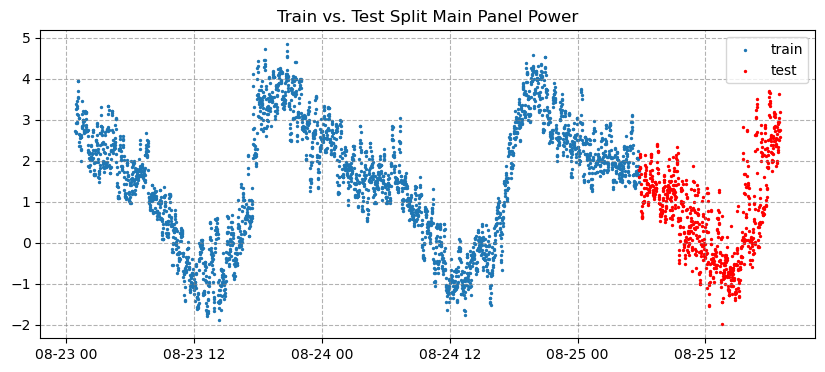

In [53]:
# training vs. testing data split
train_pct = 0.8  # set % of data to use for training
last_train_index = int(train_pct*len(avg_big_df))

trainingdata = avg_big_df.iloc[:last_train_index]
testdata = avg_big_df.iloc[last_train_index:]


# visualize data split
fig, ax = plt.subplots(figsize=(10,4))
ax.grid(linestyle='--', color='gray', alpha=0.6)
ax.scatter(trainingdata['Datetime'], trainingdata['Value'], s=2, label='train')
ax.scatter(testdata['Datetime'], testdata['Value'], s=2, label='test', color='red')
ax.legend()
ax.set_title(f"Train vs. Test Split Main Panel Power")

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.50592D-01    |proj g|=  1.33307D-02

At iterate    5    f= -1.50673D-01    |proj g|=  8.26021D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6     11      1     0     0   5.627D-05  -1.507D-01
  F = -0.15067280239508143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observati

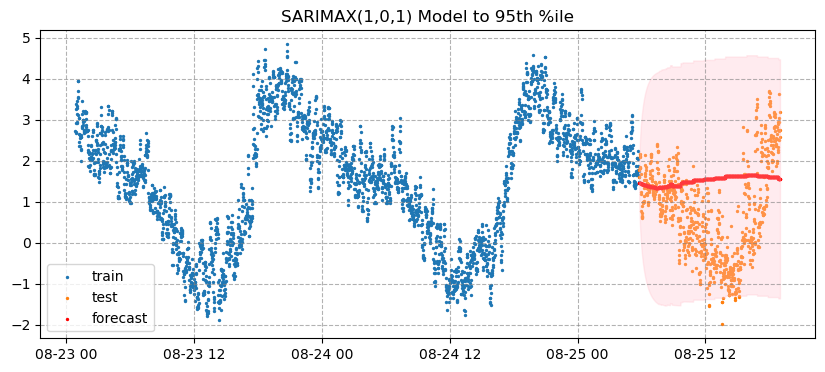

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(trainingdata['Value'], exog=trainingdata['Dry Bulb Temp F'].dropna(), order=(1,0,1)) # use best order from ARIMA testing
res = model.fit()
print(res.summary())

# forecast & rmse
forecast = res.get_forecast(steps=len(testdata), exog=testdata['Dry Bulb Temp F'])

forecast_df = pd.DataFrame({'Forecast': forecast.predicted_mean,
                            'Lower CI': forecast.conf_int().iloc[:,0],
                            'Upper CI': forecast.conf_int().iloc[:,1] })

rmse_val = rmse(forecast_df['Forecast'], testdata['Value']) # rmse


# plot test data against ARIMAX forecast
fig, ax = plt.subplots(figsize=(10,4))
ax.grid(linestyle='--', color='gray', alpha=0.6)
ax.scatter(trainingdata['Datetime'], trainingdata['Value'], s=2, label='train')
ax.scatter(testdata['Datetime'], testdata['Value'], s=2, label='test')
ax.scatter(testdata['Datetime'], forecast_df['Forecast'], s=2, label='forecast', color='red')
ax.legend()
ax.set_title(f"SARIMAX(1,0,1) Model to 95th %ile")

# plot confidence interval
ax.fill_between(testdata['Datetime'], forecast_df['Lower CI'], forecast_df['Upper CI'], color='pink', alpha=0.3)

# print RMSE
print("")
print(f"SARIMAX(1,0,1) RMSE: {round(rmse_val,4)}")

Including weather (temperature) as an exogenous driver of the power load data using a SARIMAX model resulted in a slightly more accurate time series model. Although SARIMAX(1,0,1) did not fully capture the minute-level trends of power demand, note that the observed testing values are within the 95th confidence interval of the model forecast.

Compared to ARIMA(1,0,1)'s RMSE score of 1.5, the SARIMAX(1,0,1) RMSE score was slightly lower at 1.4. The SARIMAX model forecast also depicted the oscillating behavior of the power data, entering a valley and then peaking -- note that this was not seen in any of the ARIMA model forecasts.

It can be reasonably concluded that weather is indeed a driver of energy consumption, and this fact can likely be generalized outside this isolated 3-day ERCOT Pecan Street event.

### Conclusion

Future work on refining these time series models to predict residential power demand could involve the following:
* using a dataset from a longer time-range (lower resolution, like using hourly instead of minute-level data in exchange for a longer timeframe would likely be acceptable)
* including other potential drivers of peak load (e.g. EV charging, ) as exogenous variables in the SARIMAX model
* utilizing new types of time series models (e.g. Exponential Smoothing, Neural Networks), which may perform better

New areas of analysis on energy time-series data could include:
* compare the effects of weather and temperature on different types of fueled power (fossil fuel vs. renewable energy sources)
* predicting blackouts/outages based on power demand, weather, time, etc.